# Improved Model

### Loading and prepraing the data

In [3]:
from utils.data_loader import get_flowers_dataframes, get_image_generators_from_dataframes

train_data, test_data, val_data = get_flowers_dataframes()
train_generator, test_generator, val_generator = get_image_generators_from_dataframes(train_data, test_data, val_data)

Found 192 validated image filenames belonging to 3 classes.
Found 21 validated image filenames belonging to 3 classes.
Found 27 validated image filenames belonging to 3 classes.


### Defining the network architecture

In [1]:
from keras import models, layers, regularizers

def build_network():
    network = models.Sequential()
    network.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    network.add(layers.MaxPooling2D((2, 2)))
    network.add(layers.Dropout(0.2))

    network.add(layers.Conv2D(64, (3, 3), activation='relu'))
    network.add(layers.MaxPooling2D((2, 2)))
    network.add(layers.Dropout(0.2))

    network.add(layers.Conv2D(128, (3, 3), activation='relu'))
    network.add(layers.MaxPooling2D((2, 2)))
    network.add(layers.Dropout(0.2))


    network.add(layers.Conv2D(128, (3, 3), activation='relu'))
    network.add(layers.MaxPooling2D((2, 2)))
    network.add(layers.Dropout(0.2))

    network.add(layers.Flatten())
    network.add(layers.Dense(512, activation='relu'))
    network.add(layers.Dropout(0.5))

    network.add(layers.Dense(3, activation='softmax'))

    network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return network

2024-01-14 19:38:31.219320: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 19:38:31.255128: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 19:38:31.255156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 19:38:31.256194: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-14 19:38:31.263188: I tensorflow/core/platform/cpu_feature_guar

In [1]:
# Transfer learning
from keras.applications import VGG16
from keras import models, layers
def build_transfer_learning_network():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

    for layer in base_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(base_model)

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

2024-01-15 12:43:23.561738: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 12:43:23.596993: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 12:43:23.597027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 12:43:23.598001: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 12:43:23.604677: I tensorflow/core/platform/cpu_feature_guar

In [2]:
network = build_transfer_learning_network()
network.summary()

2024-01-15 12:43:26.117592: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-15 12:43:26.144983: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-15 12:43:26.145028: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-15 12:43:26.151295: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-15 12:43:26.151355: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 27561795 (105.14 MB)
Trainable params: 12847107 (49.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


### Training and evaluating

#### Multiple runs

In [2]:
from keras.callbacks import EarlyStopping
from keras import backend
from utils.data_loader import get_flowers_dataframes, get_image_generators_from_dataframes
from tensorflow.python.framework.errors_impl import ResourceExhaustedError

highest_accuracy = 0
average_accuracy = 0

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

for i in range(0, 20):
    train_data, test_data, val_data = get_flowers_dataframes()
    train_generator, test_generator, val_generator = get_image_generators_from_dataframes(train_data, test_data, val_data)
    network = build_transfer_learning_network()
    try:
        network.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[early_stopping])
    except ResourceExhaustedError:
        print("Resource exhausted error")
        backend.clear_session()
        continue
    test_loss, test_accuracy = network.evaluate(test_generator)
    average_accuracy += test_accuracy
    if test_accuracy > highest_accuracy:
        highest_accuracy = test_accuracy
    backend.clear_session()


print("Highest accuracy: " + str(highest_accuracy))
print("Average accuracy: " + str(average_accuracy / 20))

Found 192 validated image filenames belonging to 3 classes.
Found 21 validated image filenames belonging to 3 classes.
Found 27 validated image filenames belonging to 3 classes.
Found 192 validated image filenames belonging to 3 classes.
Found 21 validated image filenames belonging to 3 classes.
Found 27 validated image filenames belonging to 3 classes.


2024-01-14 20:33:30.512924: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-14 20:33:30.542230: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-14 20:33:30.542272: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-14 20:33:30.548726: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-14 20:33:30.548778: I external/local_xla/xla/stream_executor

Epoch 1/100


2024-01-14 20:33:32.368578: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-14 20:33:32.788716: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-14 20:33:33.473691: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-14 20:33:33.528893: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe0d1314630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-14 20:33:33.528933: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-01-14 20:33:33.534766: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705264413.610089  352560 device_compiler.

20/20 [==============================] - 4s 90ms/step - loss: 1.4260 - accuracy: 0.6979 - val_loss: 0.2971 - val_accuracy: 0.8519
Epoch 2/100
20/20 [==============================] - 1s 57ms/step - loss: 0.1436 - accuracy: 0.9427 - val_loss: 0.4461 - val_accuracy: 0.8889
Epoch 3/100
20/20 [==============================] - 1s 61ms/step - loss: 0.1961 - accuracy: 0.9323 - val_loss: 0.1056 - val_accuracy: 0.9630
Epoch 4/100
20/20 [==============================] - 1s 57ms/step - loss: 0.0861 - accuracy: 0.9583 - val_loss: 0.2833 - val_accuracy: 0.8889
Epoch 5/100
20/20 [==============================] - 1s 58ms/step - loss: 0.1314 - accuracy: 0.9479 - val_loss: 0.0452 - val_accuracy: 1.0000
Epoch 6/100
20/20 [==============================] - 1s 57ms/step - loss: 0.1726 - accuracy: 0.9427 - val_loss: 0.0757 - val_accuracy: 0.9630
Epoch 7/100
20/20 [==============================] - 1s 56ms/step - loss: 0.0915 - accuracy: 0.9635 - val_loss: 0.0699 - val_accuracy: 0.9259
Epoch 8/100
20/20 

#### One Run

In [5]:
from keras.callbacks import EarlyStopping

network = build_network()
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = network.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[early_stopping])

Epoch 1/100
12/12 [==============================] - 2s 73ms/step - loss: 10.5818 - accuracy: 0.3177 - val_loss: 7.0784 - val_accuracy: 0.3704
Epoch 2/100
12/12 [==============================] - 1s 42ms/step - loss: 5.8120 - accuracy: 0.3542 - val_loss: 4.6907 - val_accuracy: 0.5556
Epoch 3/100
12/12 [==============================] - 1s 41ms/step - loss: 4.0085 - accuracy: 0.5312 - val_loss: 3.2851 - val_accuracy: 0.5185
Epoch 4/100
12/12 [==============================] - 1s 43ms/step - loss: 2.9430 - accuracy: 0.5677 - val_loss: 2.6655 - val_accuracy: 0.6296
Epoch 5/100
12/12 [==============================] - 1s 42ms/step - loss: 2.3040 - accuracy: 0.6927 - val_loss: 2.1963 - val_accuracy: 0.5926
Epoch 6/100
12/12 [==============================] - 1s 43ms/step - loss: 1.9521 - accuracy: 0.6719 - val_loss: 1.8400 - val_accuracy: 0.6667
Epoch 7/100
12/12 [==============================] - 1s 42ms/step - loss: 1.7218 - accuracy: 0.7031 - val_loss: 1.7312 - val_accuracy: 0.6667
Epoch

##### Plotting the history

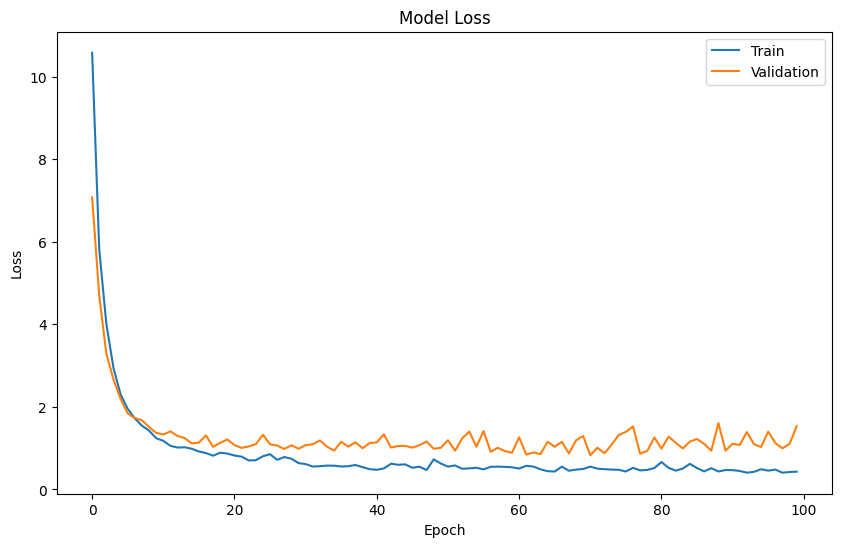

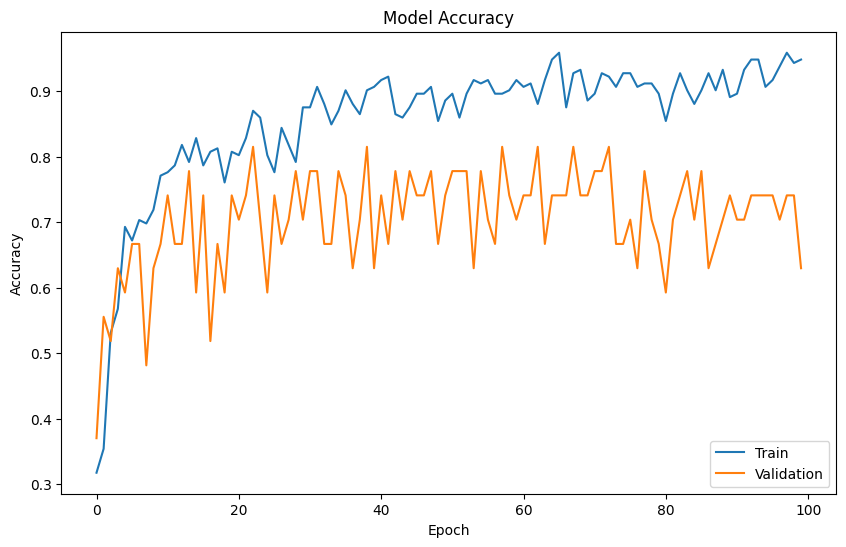

In [6]:
from utils.graph_plotter import plot_accuracy, plot_loss
plot_loss(history)
plot_accuracy(history)

##### Testing the model

In [10]:
test_loss, test_accuracy = network.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

2/2 [==============================] - 0s 10ms/step - loss: 1.2612 - accuracy: 0.8095
Test Loss: 1.261178731918335
Test Accuracy: 0.8095238208770752


### Saving and loading

In [6]:
MODEL_NAME = 'improved_model_v0'

#### History

#### Model

In [7]:
from utils.history_saver import save_history
save_history(history, MODEL_NAME)

In [ ]:
from utils.history_saver import load_history
history = load_history(MODEL_NAME)

In [7]:
from utils.model_saver import save_model
save_model(network, MODEL_NAME)

INFO:tensorflow:Assets written to: ./saved_models/improved_model_v0/assets


INFO:tensorflow:Assets written to: ./saved_models/improved_model_v0/assets


In [ ]:
from utils.model_saver import load_model
network = load_model(MODEL_NAME)